## An excellent example from Pytorch Geometric
https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

This example is from their colab notebook collection.


In [6]:
# Install required packages.
!pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt

# Explaining GNN Model Predictions using Captum

In this tutorial we demonstrate how to apply feature attribution methods to graphs. Specifically, we try to find the most important edges for each instance prediction.  

We use the Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

## Loading the dataset

We load the dataset and use 10% of the data as the test split.

In [2]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

path = '.'
dataset = TUDataset(path, name='Mutagenicity').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)
dataset.num_classes

2

In [3]:
dataset

Mutagenicity(4337)

## Visualizing the data

We define some utility functions for visualizing the molecules and draw a random molecule.

In [32]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        #print('u=',u, ' data=', data)
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    print("g=",g)
    
    return g


## Sample visualization

We sample a single molecule from train_dataset and visualize it

Data(edge_index=[2, 80], x=[37, 14], edge_attr=[80, 3], y=[1])
g= DiGraph with 37 nodes and 80 edges


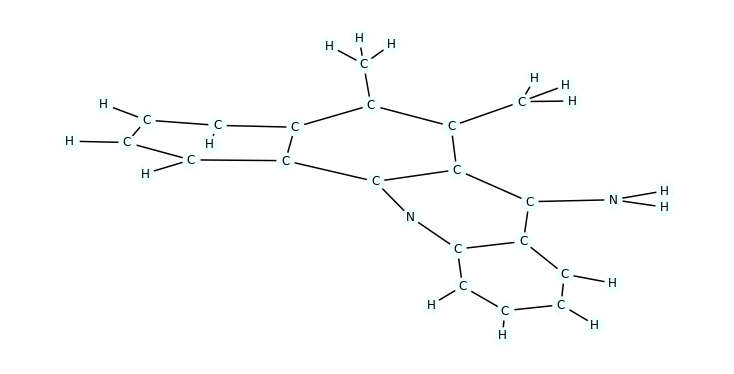

In [33]:
import random

data = random.choice([t for t in train_dataset])
print(data)
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [37]:
dataset.num_features

14

## Training the model

In the next section, we train a GNN model with 5 convolution layers. We use GraphConv which supports `edge_weight` as a parameter. Many convolution layers in Pytorch Geometric supoort this argument.

### Define the model

In [38]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


### Define train and test functions

In [40]:
for data in train_loader:
    print(data)
    break

DataBatch(edge_index=[2, 8046], x=[4289, 14], edge_attr=[8046, 3], y=[128], batch=[4289], ptr=[129])


In [39]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

### Train the model for 100 epochs

The accuracy should be around 80% in the end

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 201):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.8916, Train Acc: 0.5538, Test Acc: 0.5727
Epoch: 002, Loss: 0.6278, Train Acc: 0.6778, Test Acc: 0.6697
Epoch: 003, Loss: 0.6066, Train Acc: 0.6606, Test Acc: 0.6790
Epoch: 004, Loss: 0.5866, Train Acc: 0.7085, Test Acc: 0.6928
Epoch: 005, Loss: 0.5696, Train Acc: 0.7354, Test Acc: 0.7044
Epoch: 006, Loss: 0.5603, Train Acc: 0.7451, Test Acc: 0.7090
Epoch: 007, Loss: 0.5401, Train Acc: 0.7446, Test Acc: 0.7413
Epoch: 008, Loss: 0.5369, Train Acc: 0.7626, Test Acc: 0.7483
Epoch: 009, Loss: 0.5220, Train Acc: 0.7608, Test Acc: 0.7552
Epoch: 010, Loss: 0.5268, Train Acc: 0.7666, Test Acc: 0.7413
Epoch: 011, Loss: 0.5199, Train Acc: 0.7577, Test Acc: 0.7252
Epoch: 012, Loss: 0.5144, Train Acc: 0.7846, Test Acc: 0.7806
Epoch: 013, Loss: 0.4900, Train Acc: 0.7853, Test Acc: 0.7737
Epoch: 014, Loss: 0.4966, Train Acc: 0.7848, Test Acc: 0.7760
Epoch: 015, Loss: 0.4850, Train Acc: 0.7841, Test Acc: 0.7737
Epoch: 016, Loss: 0.4857, Train Acc: 0.7943, Test Acc: 0.7783
Epoch: 0

Epoch: 134, Loss: 0.2574, Train Acc: 0.9088, Test Acc: 0.8222
Epoch: 135, Loss: 0.2632, Train Acc: 0.9032, Test Acc: 0.8152
Epoch: 136, Loss: 0.2602, Train Acc: 0.9101, Test Acc: 0.8129
Epoch: 137, Loss: 0.2582, Train Acc: 0.9027, Test Acc: 0.8129
Epoch: 138, Loss: 0.2567, Train Acc: 0.9098, Test Acc: 0.8083
Epoch: 139, Loss: 0.2491, Train Acc: 0.9088, Test Acc: 0.8060
Epoch: 140, Loss: 0.2527, Train Acc: 0.9101, Test Acc: 0.8014
Epoch: 141, Loss: 0.2581, Train Acc: 0.9065, Test Acc: 0.8083
Epoch: 142, Loss: 0.2521, Train Acc: 0.9065, Test Acc: 0.8083
Epoch: 143, Loss: 0.2620, Train Acc: 0.8978, Test Acc: 0.8060
Epoch: 144, Loss: 0.2585, Train Acc: 0.9101, Test Acc: 0.8129
Epoch: 145, Loss: 0.2555, Train Acc: 0.8942, Test Acc: 0.8199
Epoch: 146, Loss: 0.2652, Train Acc: 0.9011, Test Acc: 0.8083
Epoch: 147, Loss: 0.2575, Train Acc: 0.9103, Test Acc: 0.8083
Epoch: 148, Loss: 0.2546, Train Acc: 0.9055, Test Acc: 0.8060
Epoch: 149, Loss: 0.2535, Train Acc: 0.9050, Test Acc: 0.8060
Epoch: 1

## Explaining the predictions

Now we look at two popular attribution methods. First, we calculate the gradient of the output with respect to the edge weights $w_{e_i}$. Edge weights are initially one for all edges.
For the saliency method, we use the absolute value of the gradient as the attribution value for each edge:

$$
Attribution_{e_i} = |\frac{\partial F(x)}{\partial w_{e_i}}|
$$

Where $x$ is the input and $F(x)$ is the output of the GNN model on input $x$.

For Integrated Gradients method, we interpolate between the current input and a baseline input where the weight of all edges is zero and accumulate the gradient values for each edge:

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha})}{\partial w_{e_i}} d\alpha
$$

Where $x_{\alpha}$ is the same as the original input graph but the weight of all edges is set to $\alpha$. Integrated Gradients complete formulation is more complicated but since our initial edge weights are equal to one and the baseline is zero, it can be simplified to the formulation above. You can read more about this method [here](https://arxiv.org/abs/1703.01365). Of course, this can not be calculated directly and is approximated by a discrete sum.

We use the [captum](https://captum.ai/) library for calculating the attribution values. We define the `model_forward` function which calculates the `batch` argument assuming that we are only explaining a single graph at a time.



In [42]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

Finally we take a random sample from the test dataset and run the explanation methods. For a simpler visualization, we make the graph undirected and merge the explanations of each edge in both directions.

It is known that NO2 substructure makes the molecules mutagenic in many cases and you can verify this by the model explanations.

Mutagenic molecules have label 0 in this dataset and we only sample from those molecules but you can change the code and see the explanations for the other class as well.

In this visualization, edge colors and thickness represent the importance. You can also see the numeric value by passing `draw_edge_labels` to `draw_molecule` function.

As you can see Integrated Gradients tend to create more accurate explanations.

g= DiGraph with 16 nodes and 32 edges


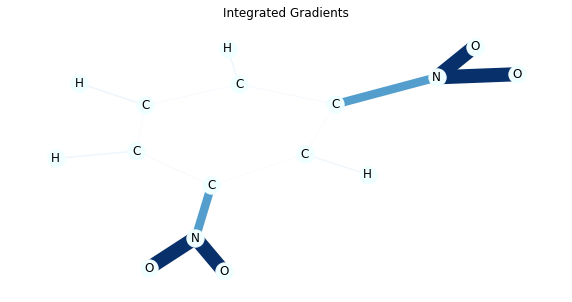

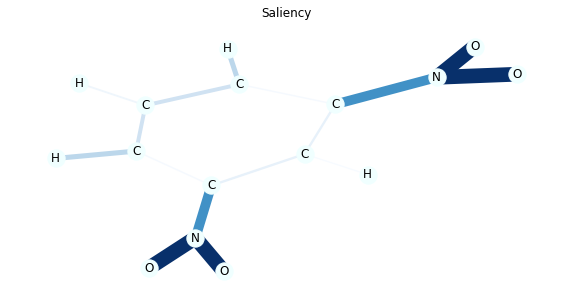

In [45]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

data = random.choice([t for t in test_dataset if not t.y.item()])
data = data.to(device)
mol = to_molecule(data)
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)